In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping,Callback,CSVLogger
from keras.models import Sequential, load_model,Model , clone_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Reshape, Input
from keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy
from keras.backend import clear_session
from keras.initializers import Constant
from threading import current_thread
from keras.utils import plot_model
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.utils import Sequence
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from keras import backend as K
from numpy.linalg import norm
from functools import partial
from random import uniform
from numpy import asarray
from copy import deepcopy
import concurrent.futures
from keras import layers
import matplotlib as mpl
from keras import Model
from numpy import save
from numpy import load
import seaborn as sns
from time import time
import pandas as pd
import numpy as np
import collections
import statistics
import warnings
import tempfile
import logging
import urllib
import random
import pickle
import pydot
import torch
import math
import html
import nltk
import os
import re
import gc

warnings.filterwarnings("ignore")
np.random.seed(123)
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
par_path = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Hiden"
model_info_path = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Results_TabuSearch/Model info"
results_path = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Results_TabuSearch"
data_path = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/DataSets"
dfs_results = "/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results"

In [4]:
def _replaceitem(x):
    if type(x) is list:
        if x[0]<0.5:return 0.0
    else:
        x=float(x)
        if x<0.5:return 0.0
    return 1.0

In [5]:
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [6]:
def get_callbacks():
  filepath = os.path.join(model_info_path,'Tabu_Search_.best.hdf5')
  history_logger = CSVLogger(os.path.join(model_info_path,'history1.csv'), separator=",", append=True)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
  es = EarlyStopping(monitor='val_loss', patience=5)
  callbacks_list = [GarbageCollectorCallback(),es] # ,history_logger,checkpoint
  return callbacks_list

In [7]:
def save_object(obj, filename,path):
    """
    _ INPUT (obj) THE OBJECT WE NEED SAVW IT (filename) THE NAME OF OBJECT
    """
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

In [8]:
def load_object(filename,path):
    """
    _ INPUT THE NAME OF OBJECT WE NEED LOAD IT
    """
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [9]:
def plot_finall_results(Best_F1_test,Best_Ac_test,Best_F1_train,Best_Ac_train,F1_test,Ac_test,F1_train,Ac_train,method_name,step=1):
  title = '2TS-DFS method Vs '+method_name
  fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', figsize=(15, 4))

  fig.suptitle(title)

  ax1.plot([i for i, x in enumerate(Best_F1_test) if i % step == 0],[x for i, x in enumerate(Best_F1_test) if i % step == 0], color="red",label="F1_Score_test")
  ax1.plot([i for i, x in enumerate(Best_Ac_test) if i % step == 0],[x for i, x in enumerate(Best_Ac_test) if i % step == 0], color="blue",label="Accurce_test")
  ax1.plot([i for i, x in enumerate(Best_F1_train) if i % step == 0],[x for i, x in enumerate(Best_F1_train) if i % step == 0], color="yellow",label="F1_Score_train")
  ax1.plot([i for i, x in enumerate(Best_Ac_train) if i % step == 0],[x for i, x in enumerate(Best_Ac_train) if i % step == 0], color="green",label="Accurce_train")

  ax1.legend(loc="best")
  ax1.set_xlabel('Chunk')
  ax1.set_ylabel('Results per Chunk')

  ax2.plot([i for i, x in enumerate(F1_test) if i % step == 0],[x for i, x in enumerate(F1_test) if i % step == 0], color="red",label="F1_Score_test")
  ax2.plot([i for i, x in enumerate(Ac_test) if i % step == 0],[x for i, x in enumerate(Ac_test) if i % step == 0], color="blue",label="Accurce_test")
  ax2.plot([i for i, x in enumerate(F1_train) if i % step == 0],[x for i, x in enumerate(F1_train) if i % step == 0], color="yellow",label="F1_Score_train")
  ax2.plot([i for i, x in enumerate(Ac_train) if i % step == 0],[x for i, x in enumerate(Ac_train) if i % step == 0], color="green",label="Accurce_train")

  ax2.legend(loc="best")
  ax2.set_xlabel('Chunk')
  ax2.set_ylabel('Results per Chunk')

  plt.savefig(os.path.join(os.path.join(results_path,'Imges'),title))
  plt.savefig(os.path.join(os.path.join(results_path,'Imges'),title+'.svg'),format='svg')
  plt.show()

In [10]:
def find_factors(number):
    factors = []
    for i in range(1, number + 1):
        if number % i == 0:
            factors.append(i)
    return factors

In [11]:
def _plot_results_for_chunk_number(chunk_number,f1=None,ac=None,pr=None,rc=None,step=None):

    plt.figure(figsize=(15, 5))
    if step is None:
      number = f1.index(max(f1)) if type(f1) is list else list(f1).index(max(f1))
      factors = find_factors(number) if number!=0 else [3,5]
      step = factors[1] if len(factors)==2 else factors[2]

    plt.title("Tabu Search results for chunk number "+str(chunk_number))
    XF = [x for i, x in enumerate(f1) if i % step == 0]
    XA = [x for i, x in enumerate(ac) if i % step == 0]
    XFT = [x for i, x in enumerate(pr) if i % step == 0]
    XAT = [x for i, x in enumerate(rc) if i % step == 0]
    save_object(XF, "F1_Score_test_"+str(chunk_number),results_path)
    save_object(XA, "Accurce_score_test_"+str(chunk_number),results_path)
    save_object(XFT, "F1_Score_train_"+str(chunk_number),results_path)
    save_object(XAT, "Accurce_score_train_"+str(chunk_number),results_path)
    plt.plot([i for i, x in enumerate(f1) if i % step == 0],[x for i, x in enumerate(f1) if i % step == 0], color="red",label="F1_Score_test")
    plt.plot([i for i, x in enumerate(ac) if i % step == 0],[x for i, x in enumerate(ac) if i % step == 0], color="blue",label="Accurce_score_test")
    plt.plot([i for i, x in enumerate(pr) if i % step == 0],[x for i, x in enumerate(pr) if i % step == 0], color="yellow",label="F1_Score_train")
    plt.plot([i for i, x in enumerate(rc) if i % step == 0],[x for i, x in enumerate(rc) if i % step == 0], color="green",label="Accurce_score_train")

    plt.scatter(f1.index(max(f1)) if type(f1) is list else list(f1).index(max(f1)), max(f1), color='orange', s=25)

    plt.vlines(x=f1.index(max(f1)) if type(f1) is list else list(f1).index(max(f1)), ymin=min([min(f1),min(f1),min(f1),min(f1)]),
               ymax=max([max(f1),max(ac),max(pr),max(rc)]), colors='black', lw=1)

    plt.hlines(y=max(f1), xmin=0,
            xmax=f1.index(max(f1)) if type(f1) is list else list(f1).index(max(f1)), colors='black', lw=1)

    plt.legend(loc="best")
    plt.xlabel('iteration')
    plt.ylabel('results per iteration')
    # plt.xscale('log',base=2)

    plt.savefig(os.path.join(os.path.join(results_path,'Imges'),"Tabu Search results for chunk number "+str(chunk_number)))
    plt.savefig(os.path.join(os.path.join(results_path,'Imges'),"Tabu Search results for chunk number "+str(chunk_number)+'.svg'),format='svg')
    plt.show()

In [12]:
def plot_results_for_chunk_number(chunk_number,f1=None,ac=None,pr=None,rc=None,step=5):

    plt.figure(figsize=(15, 5))

    plt.title("Tabu Search results for chunk number "+str(chunk_number))
    plt.plot([i for i, x in enumerate(f1) if i % step == 0],[x for i, x in enumerate(f1) if i % step == 0], color="red",label="F1_Score")
    plt.plot([i for i, x in enumerate(ac) if i % step == 0],[x for i, x in enumerate(ac) if i % step == 0], color="blue",label="Accurce_score")
    plt.plot([i for i, x in enumerate(pr) if i % step == 0],[x for i, x in enumerate(pr) if i % step == 0], color="yellow",label="Precision_score")
    plt.plot([i for i, x in enumerate(rc) if i % step == 0],[x for i, x in enumerate(rc) if i % step == 0], color="green",label="Recall_score")

    plt.legend(loc="best")
    plt.xlabel('iteration')
    plt.ylabel('results per iteration')
    plt.xscale('log',base=2)

    plt.savefig(os.path.join(os.path.join(results_path,'Imges'),"Tabu_Search_results_for_chunk_number_"+str(chunk_number)))
    plt.savefig(os.path.join(os.path.join(results_path,'Imges'),"Tabu_Search_results_for_chunk_number_"+str(chunk_number)+'.svg'),format='svg')
    plt.show()

In [13]:
import matplotlib.ticker as mticker

def plot_results(metric_name, methods_name, results, colors, step=1):
    plt.figure(figsize=(15, 5))
    plt.title(metric_name)
    for k, result in enumerate(results):
        x = [i for i, x in enumerate(results[k]) if i % step == 0]
        y = [x for i, x in enumerate(results[k]) if i % step == 0]
        plt.plot(x, y, color=colors[k], label=methods_name[k])
        plt.scatter(x, y, color=colors[k], s=20)  # Add dots to the plot

    plt.legend(loc="best")
    plt.xlabel('Chunk number')
    plt.ylabel('Results per Chunk')

    # Format x-axis ticks as integers
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(step))
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False, useMathText=True))

    plt.savefig(os.path.join(os.path.join(results_path, 'Imges'), metric_name))
    plt.savefig(os.path.join(os.path.join(results_path, 'Imges'), metric_name+'.svg'), format='svg')
    plt.show()

In [14]:
def create_list(r1, r2):
    return list(map(lambda x: x, range(r1, r2+1)))

In [15]:
def plot_dimensional_reduction(tabu,softmax,single_agent,average):
  # set width of bar
  barWidth = 0.05
  fig = plt.subplots(figsize =(8, 5))
  # Set position of bar on X axis
  br1 = np.arange(len(tabu))
  br2 = [x + barWidth for x in br1]
  br3 = [x + barWidth for x in br2]
  br4 = [x + barWidth for x in br3]
  # Make the plot
  plt.bar(br1, tabu, color ='r', width = barWidth,edgecolor ='grey', label ='2TS-DFS')
  plt.bar(br2, softmax, color ='g', width = barWidth,edgecolor ='grey', label ='ALC')
  plt.bar(br3, single_agent, color ='b', width = barWidth,edgecolor ='grey', label ='OA-OT')
  plt.bar(br4, average, color ='y', width = barWidth,edgecolor ='grey', label ='AC')
  # Adding Xticks
  plt.xlabel('Chunk number', fontweight ='bold', fontsize = 10)
  plt.ylabel('The remaining dimensions after being reduced from 100', fontweight ='bold', fontsize = 8)
  plt.xticks([r + barWidth for r in range(len(number_of_chunk))],[str(i) for i,_ in enumerate(number_of_chunk)])
  plt.legend(loc="best")
  plt.savefig(os.path.join(os.path.join(results_path,'Imges'),"Dimensional reduction amount"))
  plt.savefig(os.path.join(os.path.join(results_path,'Imges'),"Dimensional reduction amount.svg"),format='svg')
  plt.show()

In [16]:
def selected_features_for_each_cluster(tabu,number_of_chunk):
  # set width of bar
  barWidth = 0.05
  fig = plt.subplots(figsize =(15, 5))
  # Set position of bar on X axis
  br1 = np.arange(len(tabu))
  # Make the plot
  plt.bar(br1, tabu,label ='2TS-DFS') # tabu
  # Adding Xticks
  plt.xlabel('cluster number', fontweight ='bold', fontsize = 10)
  plt.ylabel('The remaining dimensions after being reduced from 100', fontweight ='bold', fontsize = 8)
  plt.xticks([r + barWidth for r in range(len(tabu))],[str(i) for i,_ in enumerate(tabu)])
  plt.savefig(os.path.join(os.path.join(results_path,'Imges'),"selected features for each cluster in chunk_"+str(number_of_chunk)))
  plt.savefig(os.path.join(os.path.join(results_path,'Imges'),"selected features for each cluster in chunk_"+str(number_of_chunk)+".svg"),format='svg')
  plt.show()

In [17]:
def evaluate_result(y_predict,y_true):
    y_predict[y_predict>0.5] = 1
    y_true = list(map(_replaceitem, y_true))
    y_predict = list(map(_replaceitem, y_predict))
    return f1_score(y_true=y_true,y_pred=y_predict),accuracy_score(y_true=y_true,y_pred=y_predict),precision_score(y_true=y_true,y_pred=y_predict),recall_score(y_true=y_true,y_pred=y_predict)

In [18]:
def apply_mask(X,mask,cluster=None):
  if cluster is None:
    for i,x in enumerate(X):
      X[i] = x*mask
  else:
    for i,x in enumerate(X):
      X[i] = x*mask[cluster[i]]
  return X

In [19]:
def load(i):
  F1_train = load_object('F1_train_'+str(i),results_path)
  F1_test = load_object('F1_test_'+str(i),results_path)
  Ac_train = load_object('Ac_train_'+str(i),results_path)
  Ac_test = load_object('Ac_test_'+str(i),results_path)
  return F1_train,F1_test,Ac_train,Ac_test

In [20]:
def get_statistical_information(X):
  new_x = []
  for x in X:
    new_x.append(np.array([np.ndarray.min(x),np.ndarray.max(x),np.ndarray.mean(x),np.ndarray.std(x),np.median(x),np.var(x)]))
  return np.array(new_x)

In [ ]:
predecting = False
number_of_chunk =[i[:-4] for i in os.listdir(par_path)[::-1] if i[:7]=='X_train']
number_of_chunk = number_of_chunk[:5]

In [ ]:
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
agglomerativeClustering = AgglomerativeClustering(n_clusters=35, affinity='euclidean')
tabu_search_model =  load_model(os.path.join(model_info_path,"tabu_search_model.h5"))
Basic_model = load_model(os.path.join("/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Results/Model info","model2.h5"))
text_cnn_model = load_model(os.path.join("/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Results_for_Entre_Static_Word_Embedding/Model info","model1.h5"))
softmax_model = load_model(os.path.join("/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results/softmax/Model info","model_with_dfs.h5"))
single_agent_model = load_model(os.path.join("/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results/single_agent/Model info","model_with_dfs.h5"))
average_model = load_model(os.path.join("/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results/average/Model info","model_with_dfs.h5"))

In [21]:
def Pad_Sequences(scripts,fit = True,creat=True):
    if fit:
        tokenizer = Tokenizer(num_words=num_words)
        tokenizer.fit_on_texts(scripts)
        save_object(tokenizer, "Pad_Sequences_tokenizer",results_path)
    else :
        tokenizer = load_object("Pad_Sequences_tokenizer",results_path)
    X = tokenizer.texts_to_sequences(scripts)
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    return X
vocab_size = 500000
num_words = 400000
maxlen = 2048
embedding_dim = 512

In [22]:
from sklearn.model_selection import train_test_split,KFold
def chunking_data(Data,test_size=0.20):
    """
    _INPUT (Data) CHUNK OF DATASET (test_size=0.20) SIZE OF SPLITNG
    _OUTPUT (X_train , y_train , X_test , y_test)
    """
    train_data, test_data = train_test_split(Data, test_size=0.2,random_state=42,shuffle=False)
    X_test = test_data[test_data.columns[-2]]
    y_test = test_data[test_data.columns[-1]]
    X_train = train_data[train_data.columns[-2]]
    y_train = train_data[train_data.columns[-1]]
    return X_train , y_train , X_test , y_test

In [ ]:
Best_F1_test,Best_Ac_test,Best_precision,Best_recall = [],[],[],[]
F1_test,Ac_test,Precision,Recall = [],[],[],[]
text_cnn_F1_test,text_cnn_Ac_test,text_cnn_precision,text_cnn_recall = [],[],[],[]
Basic_F1_test,Basic_Ac_test,Basic_precision,Basic_recall = [],[],[],[]
softmax_F1_test,softmax_Ac_test,softmax_precision,softmax_recall = [],[],[],[]
single_agent_F1_test,single_agent_Ac_test,single_agent_precision,single_agent_recall = [],[],[],[]
average_F1_test,average_Ac_test,average_precision,average_recall = [],[],[],[]
_tabu,_softmax,_single_agent,_average = [],[],[],[]
text_cnn_time,tabu_search_time,softmax_time,average_time,single_agent_time,Basic_time = [],[],[],[],[],[]

In [ ]:
for i,df_iterator in tqdm(enumerate(pd.read_csv(os.path.join(data_path,"XSS_dataset_payload.csv"),chunksize=2000))):
  if i>4:continue
# for i,_ in tqdm(enumerate(number_of_chunk)):
  df_iterator = df_iterator.mask(df_iterator.eq(np.nan)).dropna()
  S_X_train , S_y_train , S_X_test , S_y_test  = chunking_data(df_iterator)

  S_X_train = Pad_Sequences(S_X_train,fit = True)
  S_X_test = Pad_Sequences(S_X_test,fit=False)

  # X_train , y_train = load_object('X_train_hiden_for_chunk_'+str(i),par_path),load_object('y_train_hiden_for_chunk_'+str(i),par_path)
  X_test , y_test = load_object('X_test_hiden_for_chunk_'+str(i),par_path),load_object('y_test_hiden_for_chunk_'+str(i),par_path)
  # solutions = load_object('solutions_'+str(i),results_path)
  solutions_of_softmax = load_object('results_of_softmax_'+str(i),"/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results/softmax")
  solutions_of_single_agent = load_object('results_of_single_agent_'+str(i),"/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results/single_agent")
  solutions_of_average = load_object('results_of_average_'+str(i),"/content/drive/MyDrive/Colab Notebooks/Muawiya/Js_Contana/On Payload File/Featuer_selection_results/average")


  start_time = time()
  y_predicte = Basic_model.predict(X_test, verbose=0)
  end_time = time()
  prediction_time = end_time - start_time
  Basic_time.append(prediction_time)
  save_object(y_predicte, "y_predicte_js_contana_"+str(i),results_path)
  f1_test,ac_test,precision_test,recall_test = evaluate_result(y_predicte,y_test)
  Basic_F1_test.append(f1_test)
  Basic_Ac_test.append(ac_test)
  Basic_precision.append(precision_test)
  Basic_recall.append(recall_test)


  start_time = time()
  y_predicte = text_cnn_model.predict(S_X_test, verbose=0)
  end_time = time()
  prediction_time = end_time - start_time
  text_cnn_time.append(prediction_time)
  save_object(y_predicte, "y_predicte_js_contana_text_cnn_"+str(i),results_path)
  f1_test,ac_test,precision_test,recall_test = evaluate_result(y_predicte,y_test)
  text_cnn_F1_test.append(f1_test)
  text_cnn_Ac_test.append(ac_test)
  text_cnn_precision.append(precision_test)
  text_cnn_recall.append(recall_test)

  start_time = time()
  y_predicte = softmax_model.predict(apply_mask(X_test.copy(),solutions_of_softmax),verbose=0)
  end_time = time()
  prediction_time = end_time - start_time
  softmax_time.append(prediction_time)
  save_object(y_predicte, "y_predicte_softmax_model_"+str(i),results_path)
  f1_test,ac_test,precision_test,recall_test = evaluate_result(y_predicte,y_test)
  softmax_F1_test.append(f1_test)
  softmax_Ac_test.append(ac_test)
  softmax_precision.append(precision_test)
  softmax_recall.append(recall_test)

  start_time = time()
  y_predicte = single_agent_model.predict(apply_mask(X_test.copy(),solutions_of_single_agent), verbose=0)
  end_time = time()
  prediction_time = end_time - start_time
  single_agent_time.append(prediction_time)
  save_object(y_predicte, "y_predicte_single_agent_model_"+str(i),results_path)
  f1_test,ac_test,precision_test,recall_test = evaluate_result(y_predicte,y_test)
  single_agent_F1_test.append(f1_test)
  single_agent_Ac_test.append(ac_test)
  single_agent_precision.append(precision_test)
  single_agent_recall.append(recall_test)


  # tabu_search_time
  start_time = time()
  y_predicte = average_model.predict(apply_mask(X_test.copy(),solutions_of_single_agent), verbose=0)
  end_time = time()
  prediction_time = end_time - start_time
  average_time.append(prediction_time)
  save_object(y_predicte, "y_predicte_average_model_"+str(i),results_path)
  f1_test,ac_test,precision_test,recall_test = evaluate_result(y_predicte,y_test)
  average_F1_test.append(f1_test)
  average_Ac_test.append(ac_test)
  average_precision.append(precision_test)
  average_recall.append(recall_test)

  # train_clusters = agglomerativeClustering.fit_predict(get_statistical_information(X_train.copy()))
  test_clusters = agglomerativeClustering.fit_predict(get_statistical_information(X_test.copy()))
  solution = load_object('best_solution_'+str(i),results_path)
  x_test = X_test.copy()
  x_test = apply_mask(X_test,solution,test_clusters)


  start_time = time()
  y_predicte = tabu_search_model.predict(x_test, verbose=0)
  end_time = time()
  prediction_time = end_time - start_time
  tabu_search_time.append(prediction_time)
  save_object(y_predicte, "y_predicte_tabu_search_model_"+str(i),results_path)
  f1_test,ac_test,precision_test,recall_test = evaluate_result(y_predicte,y_test)
  Best_F1_test.append(f1_test)
  Best_Ac_test.append(ac_test)
  Best_precision.append(precision_test)
  Best_recall.append(recall_test)


  sums = []
  for s in solution:
    sums.append(sum(s))
  _tabu.append(np.average(sums))
  _softmax.append(sum(solutions_of_softmax))
  _single_agent.append(sum(solutions_of_single_agent))
  _average.append(sum(solutions_of_average))


  selected_features_for_each_cluster(sums,i)
  # plot_results_for_chunk_number(i,f1=F1_test,ac=Ac_test,pr=Precision,rc=Recall,step=10)

0it [00:00, ?it/s]

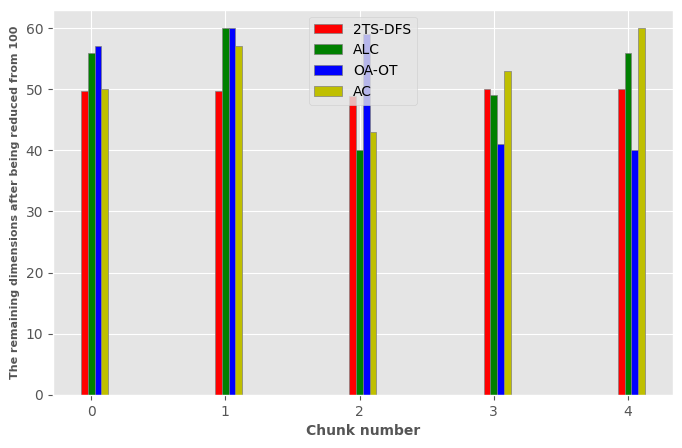

In [ ]:
save_object(_tabu, '_tabu',results_path)
save_object(_softmax, '_softmax',results_path)
save_object(_single_agent, '_single_agent',results_path)
save_object(_average, '_average',results_path)
plot_dimensional_reduction(_tabu,_softmax,_single_agent,_average)

methods_name = ['2TS-DFS','ALC','OA-OT','AC','JSContana-S','JSContana']
colors = ['r', 'g', 'b', 'm', 'c','y']


AC = [Best_Ac_test,softmax_Ac_test,single_agent_Ac_test,average_Ac_test,text_cnn_Ac_test,Basic_Ac_test]
PR = [Best_precision,softmax_precision,single_agent_precision,average_precision,text_cnn_precision,Basic_precision]
RE = [Best_recall,softmax_recall,single_agent_recall,average_recall,text_cnn_recall,Basic_recall]
F1 = [Best_F1_test,softmax_F1_test,single_agent_F1_test,average_F1_test,text_cnn_F1_test,Basic_F1_test]
pre_time = [tabu_search_time,softmax_time,single_agent_time,average_time,text_cnn_time,Basic_time]

frames = []
for i,method in enumerate(methods_name):
  result_dic = pd.DataFrame()
  result_dic['Method_name'] = [method]*5
  result_dic['Chunk_number'] = [1,2,3,4,5]
  result_dic['Accuracy_score'] = AC[i]
  result_dic['Precision_score'] = PR[i]
  result_dic['Recall_score'] = RE[i]
  result_dic['F1_score'] = F1[i]
  result_dic['Prediction_Time'] = pre_time[i]
  frames.append(result_dic)
result = pd.concat(frames)
result.to_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results.csv"),index=False)

plot_results('accuracy_score',methods_name,AC,colors,step=1)
plot_results('precision_score',methods_name,PR,colors,step=1)
plot_results('recall_score',methods_name,RE,colors,step=1)
plot_results('f1_score',methods_name,F1,colors,step=1)
plot_results('prediction_time',methods_name,pre_time,colors,step=1)

# Binary Cross-Entropy :
Binary cross-entropy is commonly used when dealing with binary classification problems.

Formula: BCE = -(1/n) * ∑(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred)), where n is the number of data points.

# Mean Absolute Error (MAE):
MAE calculates the average absolute difference between the true and predicted values.
Formula: MAE = (1/n) * ∑|y_true - y_pred|, where n is the number of data points.

# Mean Squared Error (MSE):
MSE calculates the average squared difference between the true and predicted values.
Formula: MSE = (1/n) * ∑(y_true - y_pred)^2, where n is the number of data points.

In [ ]:
def bce_f(y_true,y_pred):
  epsilon = 1e-1
  y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
  bce = -(1/len(y_true)) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
  return bce

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
methods = ['y_predicte_tabu_search_model_','y_predicte_softmax_model_','y_predicte_single_agent_model_','y_predicte_average_model_','y_predicte_js_contana_text_cnn_','y_predicte_js_contana_']
methods_name = ['2TS-DFS','ALC','OA-OT','AC','JSContana-S','JSContana']
colors = ['r', 'g', 'b', 'm', 'c','y']
BCE,MAE,MSE = [],[],[]
for _,j in enumerate(methods):
  bce,mae,mse = [],[],[]
  for i in range(5):
    y_true = load_object('y_test_hiden_for_chunk_'+str(i),par_path)
    y_pred = np.squeeze(load_object(j+str(i),results_path))
    bce.append(bce_f(y_true,y_pred))
    mae.append(mean_absolute_error(y_true, y_pred))
    mse.append(mean_squared_error(y_true, y_pred))

  BCE.append(bce)
  MAE.append(mae)
  MSE.append(mse)

plot_results('Binary Cross-Entropy',methods_name,BCE,colors,step=1)
plot_results('Mean Absolute Error',methods_name,MAE,colors,step=1)
plot_results('Mean Squared Error',methods_name,MSE,colors,step=1)
frames=[]
for i,methods in enumerate(methods):
  result_dic = pd.DataFrame()
  result_dic['Binary Cross-Entropy'] = BCE[i]
  result_dic['Mean Absolute Error'] = MAE[i]
  result_dic['Mean Squared Error'] = MSE[i]
  frames.append(result_dic)
result = pd.concat(frames)
result.to_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results2.csv"),index=False)
result1 = pd.read_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results.csv"))
result2 = pd.read_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results2.csv"))

result12 = pd.concat([result1, result2],axis = 1)
result12.to_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results.csv"),index=False)

In [ ]:
from sklearn.metrics import confusion_matrix

def calculate_fpr(y_true, y_pred):
    y_pred[y_pred>0.5] = 1
    y_true = list(map(_replaceitem, y_true))
    y_pred = list(map(_replaceitem, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
methods = ['y_predicte_tabu_search_model_','y_predicte_softmax_model_','y_predicte_single_agent_model_','y_predicte_average_model_','y_predicte_js_contana_text_cnn_','y_predicte_js_contana_']
methods_name = ['2TS-DFS','ALC','OA-OT','AC','JSContana-S','JSContana']
colors = ['r', 'g', 'b', 'm', 'c','y']
FPR = []
for _,j in enumerate(methods):
  fpr = []
  for i in range(5):
    y_true = load_object('y_test_hiden_for_chunk_'+str(i),par_path)
    y_pred = np.squeeze(load_object(j+str(i),results_path))
    fpr.append(calculate_fpr(y_true, y_pred))
  FPR.append(fpr)

plot_results('False Positive Rate',methods_name,FPR,colors,step=1)
frames=[]
for i,methods in enumerate(methods):
  result_dic = pd.DataFrame()
  result_dic['False Positive Rate'] = FPR[i]
  frames.append(result_dic)
result = pd.concat(frames)
result.to_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results2.csv"),index=False)
result1 = pd.read_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results.csv"))
result2 = pd.read_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results2.csv"))

result12 = pd.concat([result1, result2],axis = 1)
result12.to_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results.csv"),index=False)

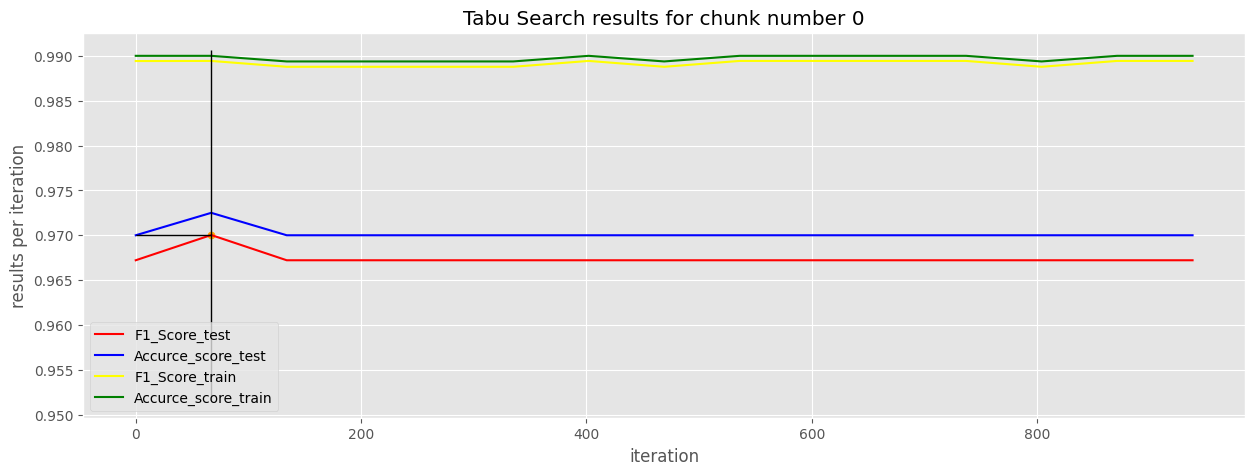

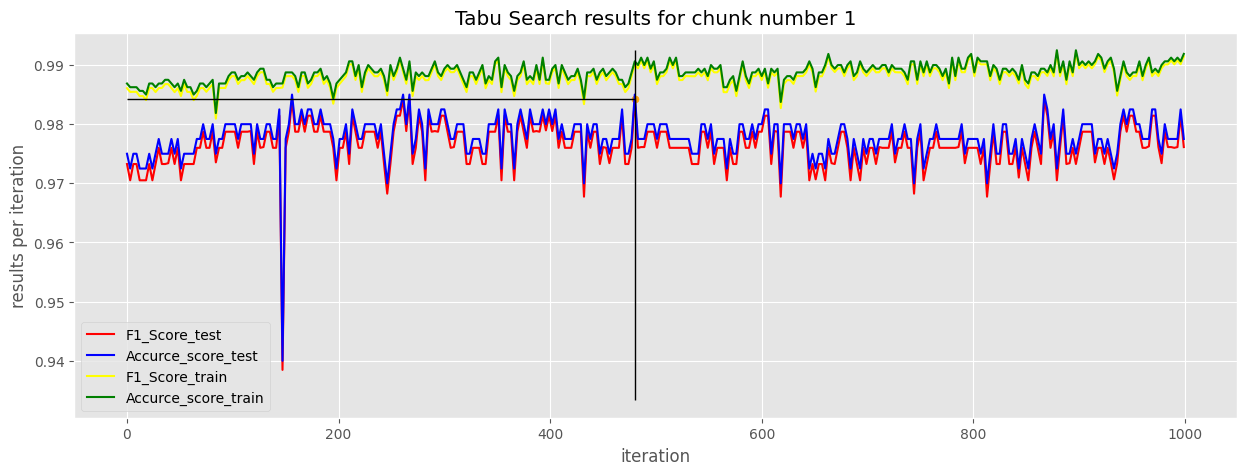

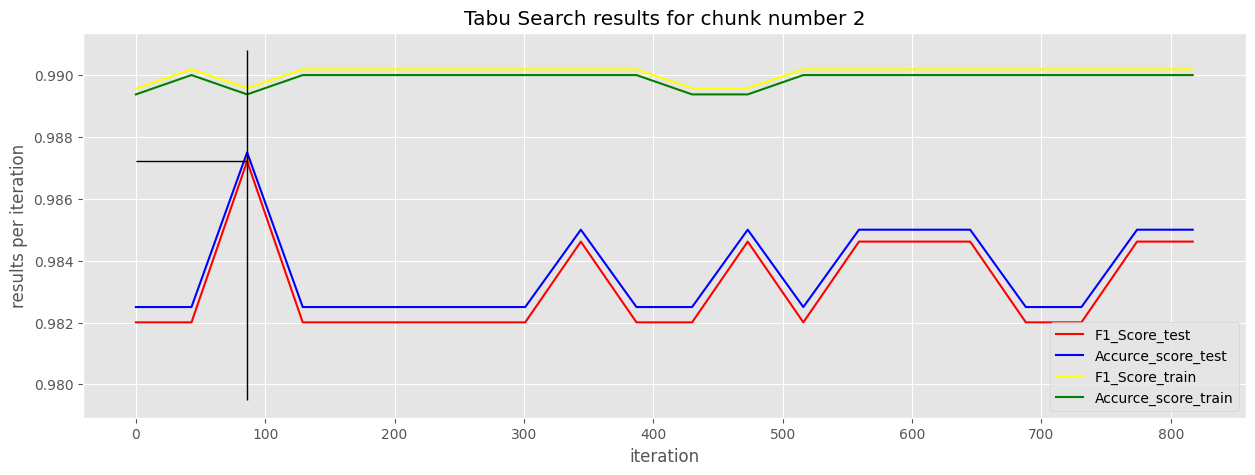

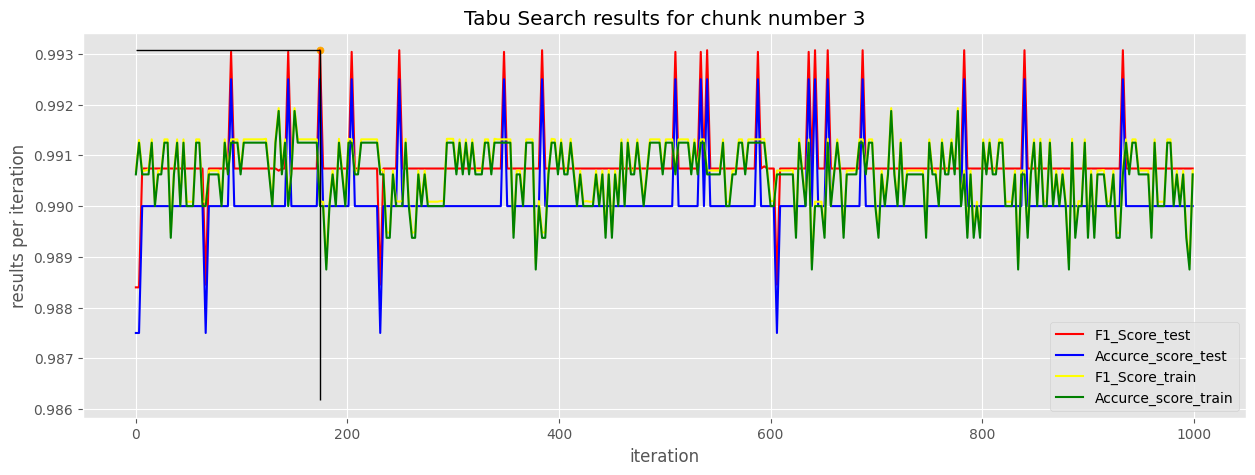

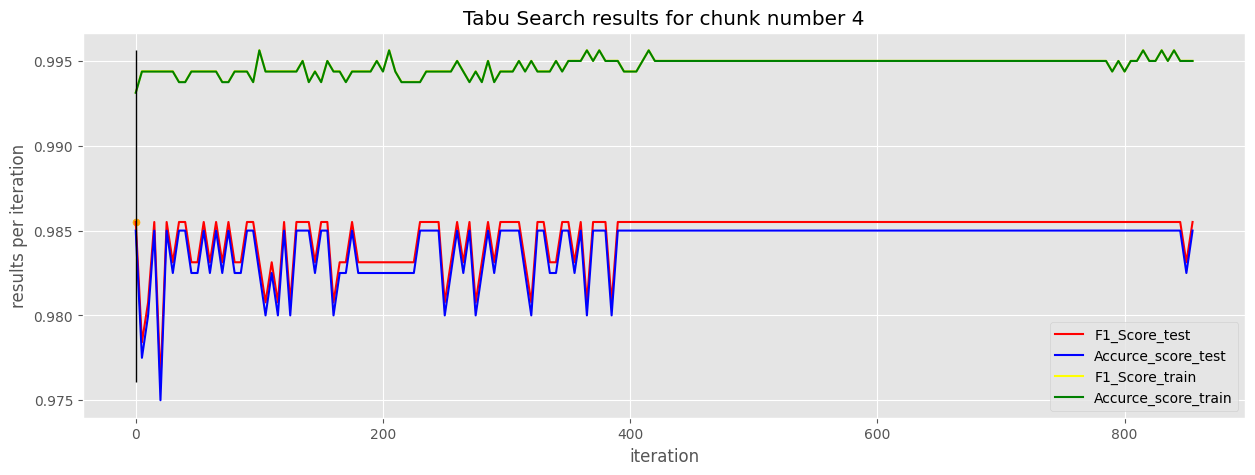

In [23]:
for i in range(5):
  F1_train,F1_test,Ac_train,Ac_test = load(i)
  _plot_results_for_chunk_number(i,f1=F1_test,ac=Ac_test,pr=F1_train,rc=Ac_train) # step

In [ ]:
subheadings = ["Chunk 0", "Chunk 1","Chunk 2","Chunk 3","Chunk 4"]
column_headings = ["F1_train", "F1_test", "Ac_train","Ac_test"]
columns = pd.MultiIndex.from_product([subheadings, column_headings])
df = pd.DataFrame(columns=columns)
df = df.reindex(columns=pd.MultiIndex.from_tuples(df.columns, names=columns.names), fill_value=np.nan)
for i in range(5):
  F1_train,F1_test,Ac_train,Ac_test = load(i)
  if len(F1_train) < 1000:
    F1_train = F1_train+[-1]*(1000-len(F1_train))
    F1_test = F1_test+[-1]*(1000-len(F1_test))
    Ac_train = Ac_train+[-1]*(1000-len(Ac_train))
    Ac_test = Ac_test+[-1]*(1000-len(Ac_test))

  df['Chunk '+str(i),'F1_train'] = F1_train
  df['Chunk '+str(i),'F1_test'] = F1_test
  df['Chunk '+str(i),'Ac_train'] = Ac_train
  df['Chunk '+str(i),'Ac_test'] = Ac_test
print(df.shape)
df.to_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical Value for chunks.csv"),index=False)
df.head()

(1000, 20)


Chunk 0                              Chunk 1                              \
   F1_train   F1_test Ac_train Ac_test  F1_train   F1_test  Ac_train Ac_test   
0  0.989418  0.967213     0.99    0.97  0.986083  0.973262  0.986875  0.9750   
1  0.989418  0.967213     0.99    0.97  0.984085  0.970509  0.985000  0.9725   
2  0.989418  0.967213     0.99    0.97  0.986120  0.970509  0.986875  0.9725   
3  0.989418  0.967213     0.99    0.97  0.985450  0.970509  0.986250  0.9725   
4  0.989418  0.967213     0.99    0.97  0.985450  0.970509  0.986250  0.9725   

    Chunk 2                               Chunk 3                              \
   F1_train   F1_test  Ac_train Ac_test  F1_train   F1_test  Ac_train Ac_test   
0  0.989564  0.982005  0.989375  0.9825  0.990689  0.988399  0.990625  0.9875   
1  0.988971  0.982005  0.988750  0.9825  0.991304  0.990741  0.991250  0.9900   
2  0.989564  0.984615  0.989375  0.9850  0.990689  0.988399  0.990625  0.9875   
3  0.989564  0.982005  0.989375  0.9825  0.991304  0.988399  0.991250  0.9875   
4  0.990184  0.982005  0.990000  0.9825  0.990689  0.988399  0.990625  0.9875   

    Chunk 4                              
   F1_train   F1_test  Ac_train Ac_test  
0  0.993146  0.985507  0.993125  0.9850  
1  0.994393  0.983133  0.994375  0.9825  
2  0.994393  0.978417  0.994375  0.9775  
3  0.993758  0.983133  0.993750  0.9825  
4  0.993773  0.983133  0.993750  0.9825

In [ ]:
columns = ["Cluster Number","Chunk 0", "Chunk 1","Chunk 2","Chunk 3","Chunk 4"]
df = pd.DataFrame(columns=columns)
for i in range(5):
  solution = load_object('best_solution_'+str(i),results_path)
  sums = []
  for s in solution:
    sums.append(sum(s))
  df['Chunk '+str(i)] = sums
df['Cluster Number'] = [*range(len(sums))]
print(df.shape)
df.to_csv(os.path.join(os.path.join(results_path,'Imges'),"Number of remaining dimensions after being reduction from 100.csv"),index=False)
df.head()

(35, 6)


,Cluster Number,Chunk 0,Chunk 1,Chunk 2,Chunk 3,Chunk 4
0,0,40,51,60,46,45
1,1,45,51,47,50,53
2,2,47,48,52,51,55
3,3,56,52,50,47,53
4,4,46,51,47,49,52


In [ ]:
df1 = pd.read_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical Value for chunks.csv"))
df2 = pd.read_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical results.csv"))

In [ ]:
for i in range(5):
  print("============================================")
  print()
  ac = "Chunk "+str(i)+".1" # ac
  f1 = "Chunk "+str(i)+".3" # f1
  xx = max(df1[ac][1:])
  print("The difference between the value of Ac_test during training and after saving the model for chunk number "+str(i)+" = ",float(xx)-df2['Accuracy_score'][i])
  ff = max(df1[f1][1:])
  print("The difference between the value of F1_test during training and after saving the model = "+str(i)+" = ",float(ff)-df2['F1_score'][i])


The difference between the value of Ac_test during training and after saving the model for chunk number 0 =  -0.00247275204359676
The difference between the value of F1_test during training and after saving the model = 0 =  0.002472752043596871

The difference between the value of Ac_test during training and after saving the model for chunk number 1 =  0.00679319371727749
The difference between the value of F1_test during training and after saving the model = 1 =  0.009000000000000008

The difference between the value of Ac_test during training and after saving the model for chunk number 2 =  0.004712276214833833
The difference between the value of F1_test during training and after saving the model = 2 =  0.005494858611825193

The difference between the value of Ac_test during training and after saving the model for chunk number 3 =  0.005571593533487129
The difference between the value of F1_test during training and after saving the model = 3 =  0.004100928074246002

The difference b

In [24]:
def new_laod(chunk_number):
  F1_train = load_object("F1_Score_test_"+str(chunk_number),results_path)
  F1_test = load_object("Accurce_score_test_"+str(chunk_number),results_path)
  Ac_train = load_object("F1_Score_train_"+str(chunk_number),results_path)
  Ac_test = load_object("Accurce_score_train_"+str(chunk_number),results_path)
  return F1_train,F1_test,Ac_train,Ac_test

In [28]:
subheadings = ["Chunk 0", "Chunk 1","Chunk 2","Chunk 3","Chunk 4"]
column_headings = ["F1_train", "F1_test", "Ac_train","Ac_test"]
columns = pd.MultiIndex.from_product([subheadings, column_headings])
df = pd.DataFrame(columns=columns)
for i in range(5):
  F1_train,F1_test,Ac_train,Ac_test = new_laod(i)
  max = 334
  F1_train = F1_train+[-1]*(max-len(F1_train))
  F1_test = F1_test+[-1]*(max-len(F1_test))
  Ac_train = Ac_train+[-1]*(max-len(Ac_train))
  Ac_test = Ac_test+[-1]*(max-len(Ac_test))
  df['Chunk '+str(i),'F1_train'] = F1_train
  df['Chunk '+str(i),'F1_test'] = F1_test
  df['Chunk '+str(i),'Ac_train'] = Ac_train
  df['Chunk '+str(i),'Ac_test'] = Ac_test
print(df.shape)
df.to_csv(os.path.join(os.path.join(results_path,'Imges'),"Numerical Value for chunks after sikp.csv"),index=False)
df.head()

(334, 20)


Chunk 0                               Chunk 1                              \
   F1_train F1_test  Ac_train   Ac_test  F1_train F1_test  Ac_train   Ac_test   
0  0.967213  0.9700  0.989418  0.990000  0.973262  0.9750  0.986083  0.986875   
1  0.970027  0.9725  0.989432  0.990000  0.970509  0.9725  0.985450  0.986250   
2  0.967213  0.9700  0.988779  0.989375  0.973262  0.9750  0.985469  0.986250   
3  0.967213  0.9700  0.988779  0.989375  0.973262  0.9750  0.985469  0.986250   
4  0.967213  0.9700  0.988779  0.989375  0.970509  0.9725  0.984738  0.985625   

    Chunk 2                               Chunk 3                              \
   F1_train F1_test  Ac_train   Ac_test  F1_train F1_test  Ac_train   Ac_test   
0  0.982005  0.9825  0.989564  0.989375  0.988399  0.9875  0.990689  0.990625   
1  0.982005  0.9825  0.990184  0.990000  0.988399  0.9875  0.991304  0.991250   
2  0.987212  0.9875  0.989577  0.989375  0.990741  0.9900  0.990689  0.990625   
3  0.982005  0.9825  0.990184  0.990000  0.990741  0.9900  0.990701  0.990625   
4  0.982005  0.9825  0.990184  0.990000  0.990741  0.9900  0.990724  0.990625   

    Chunk 4                              
   F1_train F1_test  Ac_train   Ac_test  
0  0.985507  0.9850  0.993146  0.993125  
1  0.978417  0.9775  0.994393  0.994375  
2  0.980769  0.9800  0.994393  0.994375  
3  0.985507  0.9850  0.994393  0.994375  
4  0.976077  0.9750  0.994393  0.994375